In [8]:
from timeit import default_timer as timer
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np
from math import ceil, floor,  pi, sqrt
import scipy.ndimage


In [9]:
def gaussDeriv2D(sigma):
    x = np.array(range(0, 6*ceil(sigma)))
    y = np.transpose(x)
    Gx = ((x-3*ceil(sigma))/(2*pi*sigma**4)) * \
        (np.exp(-(((x-3*ceil(sigma))**2+(y-3*ceil(sigma))**2)/(2*sigma**2))))
    Gy = ((y-3*ceil(sigma))/(2*pi*sigma**4)) * \
        (np.exp(-(((x-3*ceil(sigma))**2+(y-3*ceil(sigma))**2)/(2*sigma**2))))
    return [Gx, Gy[np.newaxis]]

R(16:22, 16:22)
[[9.4303232e-06 9.4295740e-02 5.7676709e+03 4.0085055e+04 4.0086871e+04
  5.7691885e+03]
 [2.9679966e-05 2.3198745e-01 1.3079803e+04 9.0825930e+04 9.0828836e+04
  1.3082229e+04]
 [7.3343451e+02 1.6830077e+03 5.0502644e+07 3.5047005e+08 3.5047018e+08
  5.0502736e+07]
 [5.1437925e+03 1.1641759e+04 3.4558707e+08 2.3980083e+09 2.3980086e+09
  3.4558720e+08]
 [5.1434956e+03 1.1621152e+04 3.4450678e+08 2.3905129e+09 2.3905132e+09
  3.4450698e+08]
 [7.3315387e+02 1.6546970e+03 4.9011880e+07 3.4012544e+08 3.4012554e+08
  4.9011964e+07]]


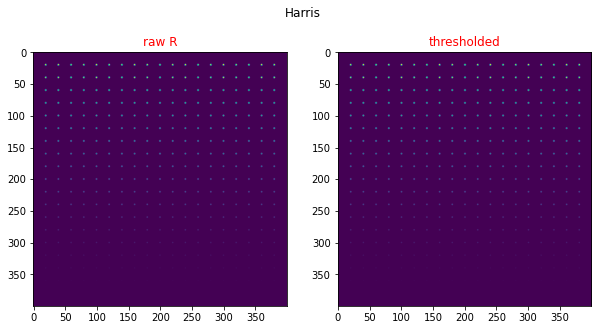

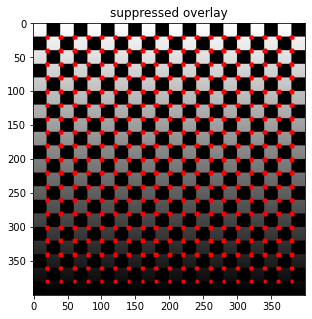

In [10]:
checker = plt.imread('checker.png')*255
alpha = 0.05
dx, dy = gaussDeriv2D(0.7)

ix = cv2.filter2D(checker, -1, dx)
iy = cv2.filter2D(checker, -1, dy)

ix2 = np.square(ix)
iy2 = np.square(iy)
ixiy = ix @ iy

gx = cv2.GaussianBlur(ix2, (3, 3), 1)
gy = cv2.GaussianBlur(iy2, (3, 3), 1)
gxgy = cv2.GaussianBlur(ixiy, (3, 3), 1)

R = gx*gy - np.square(gxgy) - alpha*np.square(gx+gy)
# for some reason I get negative significant values instead of positive?
R = -R
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(R)
plt.gca().set_title('raw R', c='r')
# remove vals less than 1e6
threshold = np.where(R < 1e6, 0, R)
plt.subplot(1, 2, 2)
plt.imshow(threshold)
plt.gca().set_title('thresholded', c='r')
print('R(16:22, 16:22)')
print(R[16:22, 16:22])

w_size = 3
limits = threshold.shape[0]-w_size, threshold.shape[1]-w_size
suppress = []
for r, c in np.ndindex(limits):
    region = threshold[r-1:r+1, c-1:c+1]
    if np.unique(region).size > 0:
        if np.max(np.unique(region)) > 0:
            suppress.append((c, r))

plt.suptitle('Harris')
plt.show()

plt.figure(figsize=(5, 5))
plt.gca().imshow(checker, cmap='gray')
plt.gca().scatter(*zip(*suppress), s=0.5, c='r')
plt.title('suppressed overlay')
plt.show()


 I didn't notice much of a difference between the raw R values and the thresholded values. In addition, when I calculated the raw R values, the points where corners where detected were large negative values instead of large positive values as expected, so I multiplied all values by -1. This most likely has something to do with the orientation of the derivative gaussian. It was interesting that the brightness gradient affected the detection of the corners, because the difference between squares decreased as the image got darker. However, this was resolved by the non maximal suppression, which saved the relative maxes. 

In [11]:
def fast(img, T):
    offsets = [(3, 0),
               (3, 1),
               (2, 2),
               (1, 3),
               (0, 3),
               (-1, 3),
               (-2, 2),
               (-3, 1),
               (-3, 0),
               (-3, -1),
               (-2, -2),
               (-1, -3),
               (0, -3),
               (1, -3),
               (-2, 2),
               (3, -1)]
    features = []
    for r, c in np.ndindex(img.shape):

        vals = np.array([img[r+dr, c+dc] for dr, dc in offsets
                if r+dr >= 0 and r+dr < img.shape[0] and c+dc >= 0 and c+dc < img.shape[1]])
        vals = np.hstack((vals, vals))

        head = 0
        tail = 0
        while tail <= len(vals) - 9:
            if tail - head >= 9:
                features.append((c, r))
                break
            elif vals[tail] > img[r, c] + T:
                tail += 1
            else:
                head = tail
                tail = head+1

        while tail <= len(vals) - 9:
            if tail - head >= 9:
                features.append((c, r))
                break
            elif vals[tail] < img[r, c] - T:
                tail += 1
            else:
                head = tail
                tail = head+1
    return features



Text(0.5, 0.98, 'FAST')

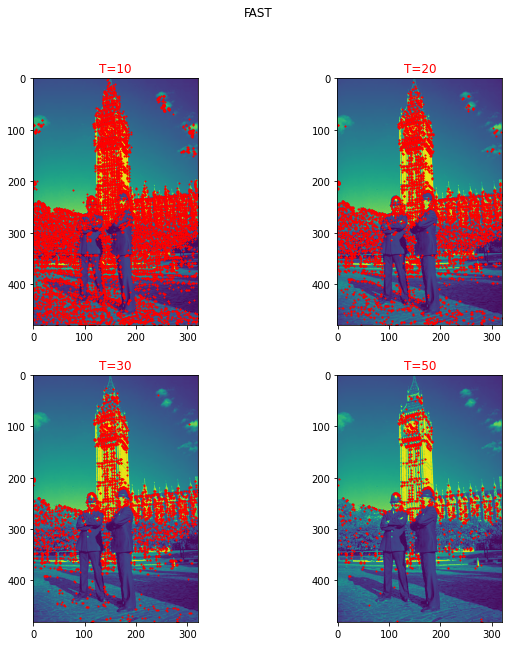

In [12]:
img = plt.imread('tower.png') * 255
plt.figure(figsize=(10, 10))
for i, T in enumerate([10, 20, 30, 50]):
    plt.subplot(2, 2, i+1)
    features = fast(img, T)
    plt.gca().imshow(img)
    plt.gca().scatter(*zip(*features), s=0.5, c='r')
    plt.gca().set_title(f'T={T}', c='r')
    end = timer()
plt.suptitle('FAST')

Comparing the FAST results with increasing thresholds, you can see that the number of corners detected decreases with each increase. With T=10, the results are essentially unusable, as about half of image is covered in corner points. T=50 is much better, with a lot of the unneccesary points removed. However, the trees in the background are definitely an issue for this algorithm, as there are many detected corners in the trees that cloud the overall image. FAST did a very good job at detecting the steeple tips and the ridges on Big Ben. 